# Task 4.1 - Variational Auto-Encoder

The first part of the task requires the construction of a Variational Auto-Encoder (VAE) for magnetic resonance (MR) images of the brain via the Preprocessed OASIS Dataset. The OASIS dataset was retrieved from /home/groups/comp3710/ directory on the Rangpur cluster.

Full marks for this section require the training of the model on the dataset and the visualisation of the resulting manifold output from the VAE. Visualisation can be done using sampling methods to create a 2D image, or using a dimensionality reduction technique such as a UMAP.

## Tutorial

Reference for material, see [Medium's Variational Autoencoder (VAE) - PyTorch Tutorial](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f)

In [80]:
# Code block
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

In [81]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'D:/Files/University/Courses/Year 5/COMP3702/code/lab_2/data'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

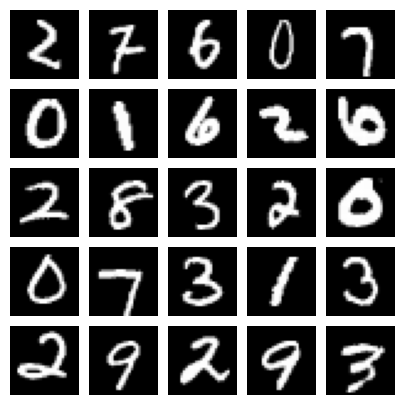

In [82]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [83]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [84]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [85]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [86]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, -1).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  177.1013512266538
	Epoch 2 	Average Loss:  157.41112228062394
	Epoch 3 	Average Loss:  153.16162516955342
	Epoch 4 	Average Loss:  150.57402827955445
	Epoch 5 	Average Loss:  148.55595662366966
	Epoch 6 	Average Loss:  146.99118845536833
	Epoch 7 	Average Loss:  145.6389872443656
	Epoch 8 	Average Loss:  144.4779471971515
	Epoch 9 	Average Loss:  143.66297890690214


KeyboardInterrupt: 

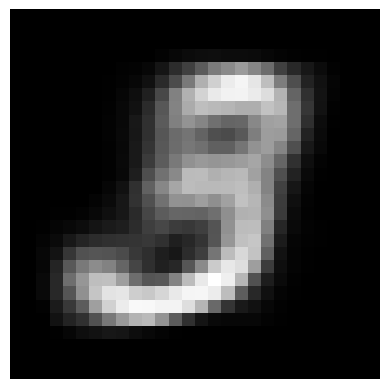

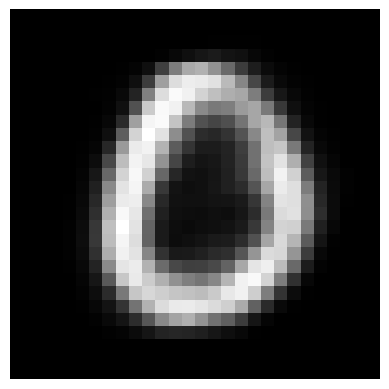

(None, None)

In [87]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

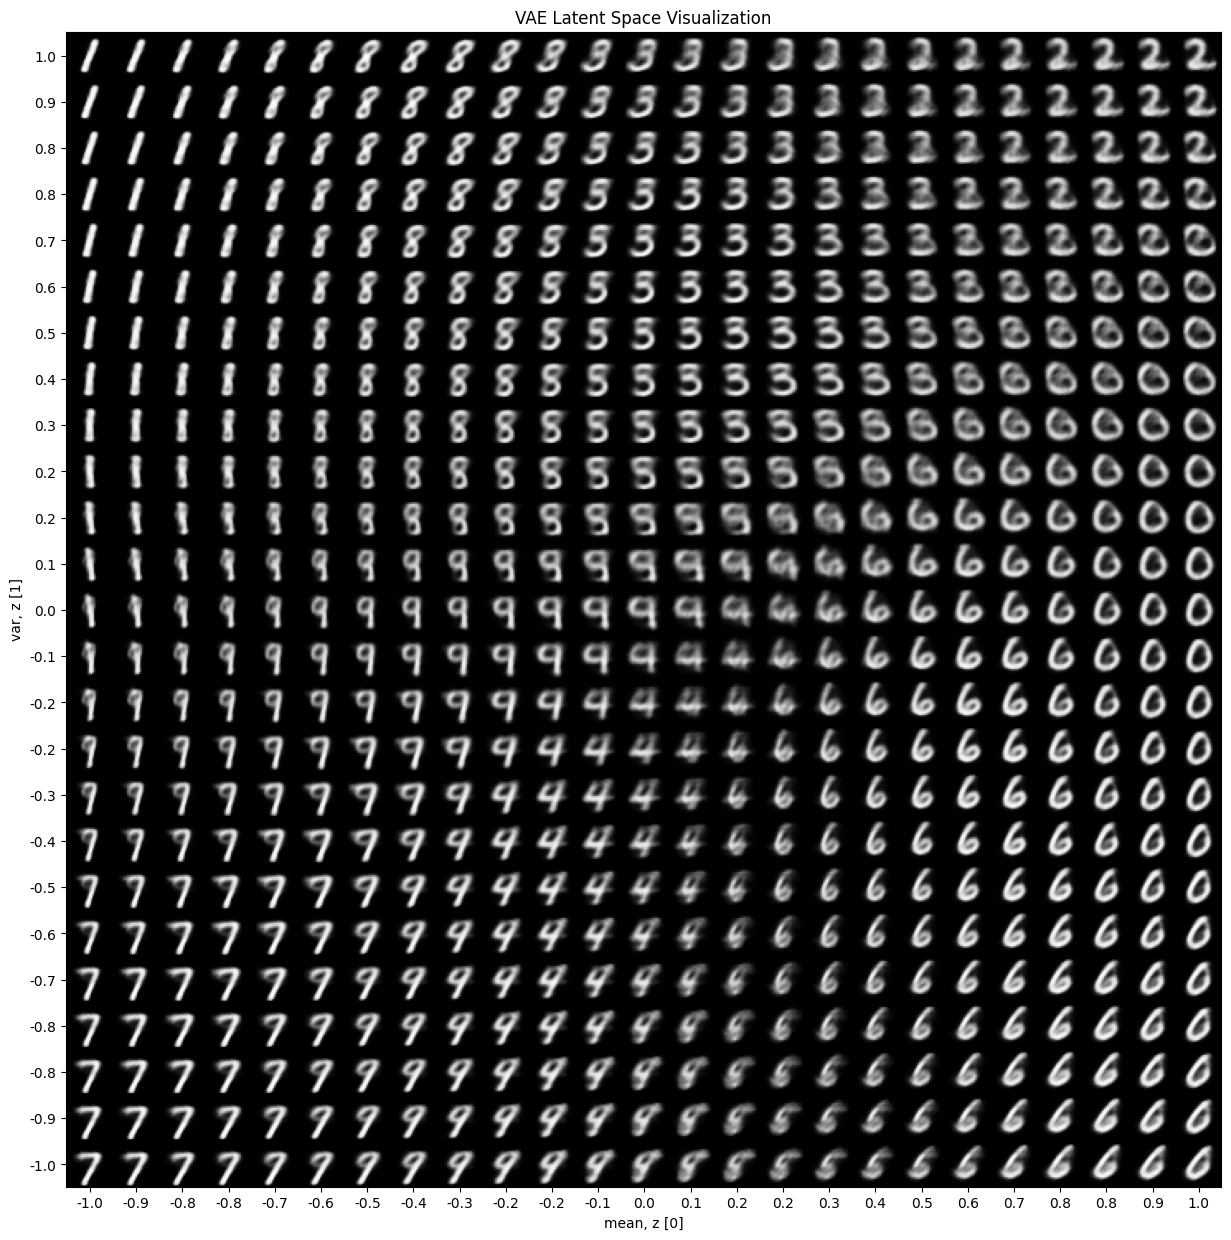

In [88]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(model)

C:\Users\Connor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


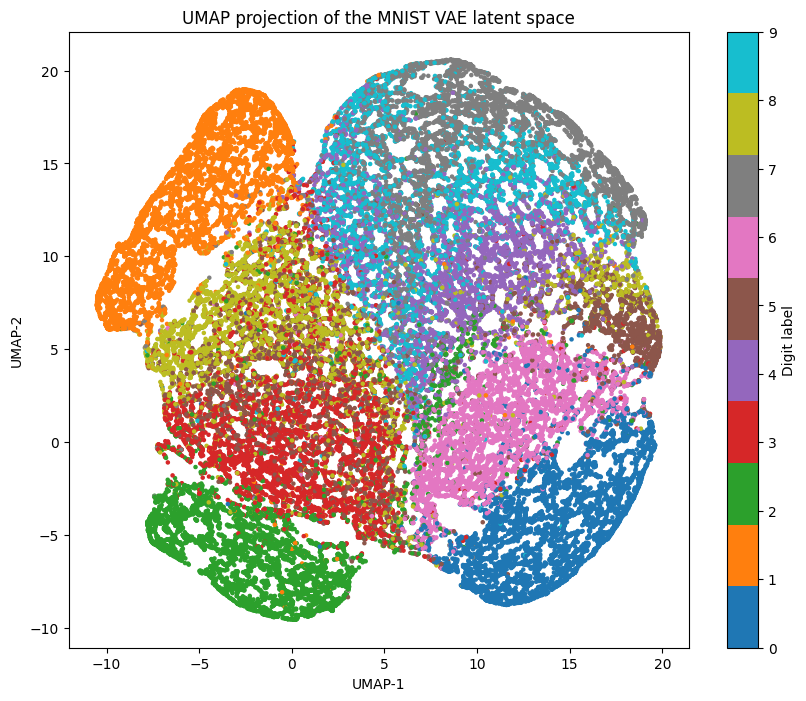

In [94]:
# Use UMAP to visualise the latent space
import umap

# Set the model to evaluation mode
model.eval()

# Collect latent vectors and labels for the test set
latent_vectors = []
labels = []

for x, y in test_loader:
    with torch.no_grad():
        x = x.view(x.size(0), -1).to(device)
        mean, logvar = model.encode(x)
        latent_vectors.append(mean.cpu().numpy())
        labels.append(y.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit label')
plt.title('UMAP projection of the MNIST VAE latent space')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Actual

Now let's try to do the same but for the keras png slices data

In [110]:
# Code block
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

import os
from PIL import Image

We must first recognise that the photos are all greyscale (single channel 0 to 255), and are square with a height and width of 256x256 respectively.

In [111]:
# Import the training images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'D:/Files/University/Courses/Year 5/COMP3702/code/lab_2/data/keras_png_slices_data'
train_folder = '/keras_png_slices_train/'
validate_folder = '/keras_png_slices_validate/'
test_folder = '/keras_png_slices_test/'

# Transform to convert PIL image to tensor 
transform = transforms.Compose([
    transforms.ToTensor(),                        # Convert to [0, 1] tensor
])

# Load and transform all images
train_image_tensors = []

def import_photos(folder_name):
    image_tensors = []
    
    for filename in os.listdir(path + folder_name):
        if filename.lower().endswith(('.png')):
            img_path = os.path.join(path + folder_name, filename)
            img = Image.open(img_path).convert('L')  # 'L' mode = grayscale
            tensor = transform(img)  # Shape: [1, 256, 256]
            image_tensors.append(tensor)

    # Convert to big tensor
    dataset = torch.stack(image_tensors)
    
    return dataset

train_dataset = import_photos(train_folder)
validate_dataset = import_photos(validate_folder)
test_dataset = import_photos(test_folder)

print("Datasets imported successfully.")
print(train_dataset.shape) 
print(test_dataset.shape)  
print(validate_dataset.shape) 


Datasets imported successfully.
torch.Size([9664, 1, 256, 256])
torch.Size([544, 1, 256, 256])
torch.Size([1120, 1, 256, 256])


In [112]:
print(train_dataset[4][0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [113]:
# As the images are already scaled between 0 and 1, there is no need for further 
# normalization. Instead, just batch the data using DataLoader.

# Load Images
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

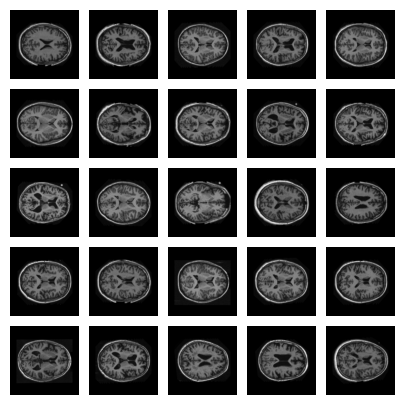

In [114]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[i, 0, :, :] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

This takes the original CNN code from the lecture, but note that is only for an autoencoder. The key difference between an autoencoder and a Variational Autoencoder is mainly in the latent space. Primarily, the output of the encoder in an autoencoder is a single latent vector z, whereas VAE has an output of mu and std deviation to sample z from a normal distribution. Additionally, the loss function is not usually MSE but instead maximise likelihood by the ELB (Reconstruction Loss + KL Divergence)

In [115]:
# Now we generate our VAE model - use the example code from the lecture
class CNN_VAE(nn.Module):

    def __init__(self, latent_dim=1024, latent_dim_z=128, device=device):
        super(CNN_VAE, self).__init__()

        
        # Encoder with Max Pooling instead of stride
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (B, 1, 256, 256) -> (B, 32, 256, 256)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 32, 256, 256) -> (B, 32, 128, 128)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (B, 32, 128, 128) -> (B, 64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 64, 128, 128) -> (B, 64, 64, 64)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (B, 64, 64, 64) -> (B, 128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 128, 64, 64) -> (B, 128, 32, 32)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (B, 128, 32, 32) -> (B, 256, 32, 32)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 256, 32, 32) -> (B, 256, 16, 16)

            # Encoder Conv2d bottleneck
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, 8, 8) # Reduces because of stride 2
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Flatten(),                                 # (B, 128, 8, 8) -> (B, 8192)
            nn.Linear(128*8*8, latent_dim) # (B, 8192) -> (B, latent_dim)          
        )

        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim_z)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim_z)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim_z, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),               # (B, latent_dim) -> (B, 128, 8, 8)

            # Decoder Conv2d bottleneck
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),    # (B, 128, 8, 8) -> (B, 256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),    # (B, 256, 16, 16) -> (B, 128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # (B, 128, 32, 32) -> (B, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),     # (B, 64, 64, 64) -> (B, 32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),      # (B, 32, 128, 128) -> (B, 1, 256, 256)
            nn.Sigmoid() #[0, 1] output
            )
    
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation using standard identity
            epsilon = torch.randn_like(std).to(device)
            z = mean + std * epsilon
            return z
        else:
            return mean  # During evaluation, use the mean as the latent vector 

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [116]:
vae = CNN_VAE().to(device)
optimizer = Adam(vae.parameters(), lr=1e-3)

In [ ]:
def vae_loss_function(x, x_hat, mean, log_var, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    beta: weight for KL divergence (beta-VAE)
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL divergence loss
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return BCE + beta * KLD, BCE, KLD

In [119]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss, bce, kld = vae_loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(vae, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  20900.629931478405
	Epoch 2 	Average Loss:  16902.26979404589
	Epoch 3 	Average Loss:  16619.99207070183
	Epoch 4 	Average Loss:  16480.212867914244
	Epoch 5 	Average Loss:  16401.75503205461


KeyboardInterrupt: 

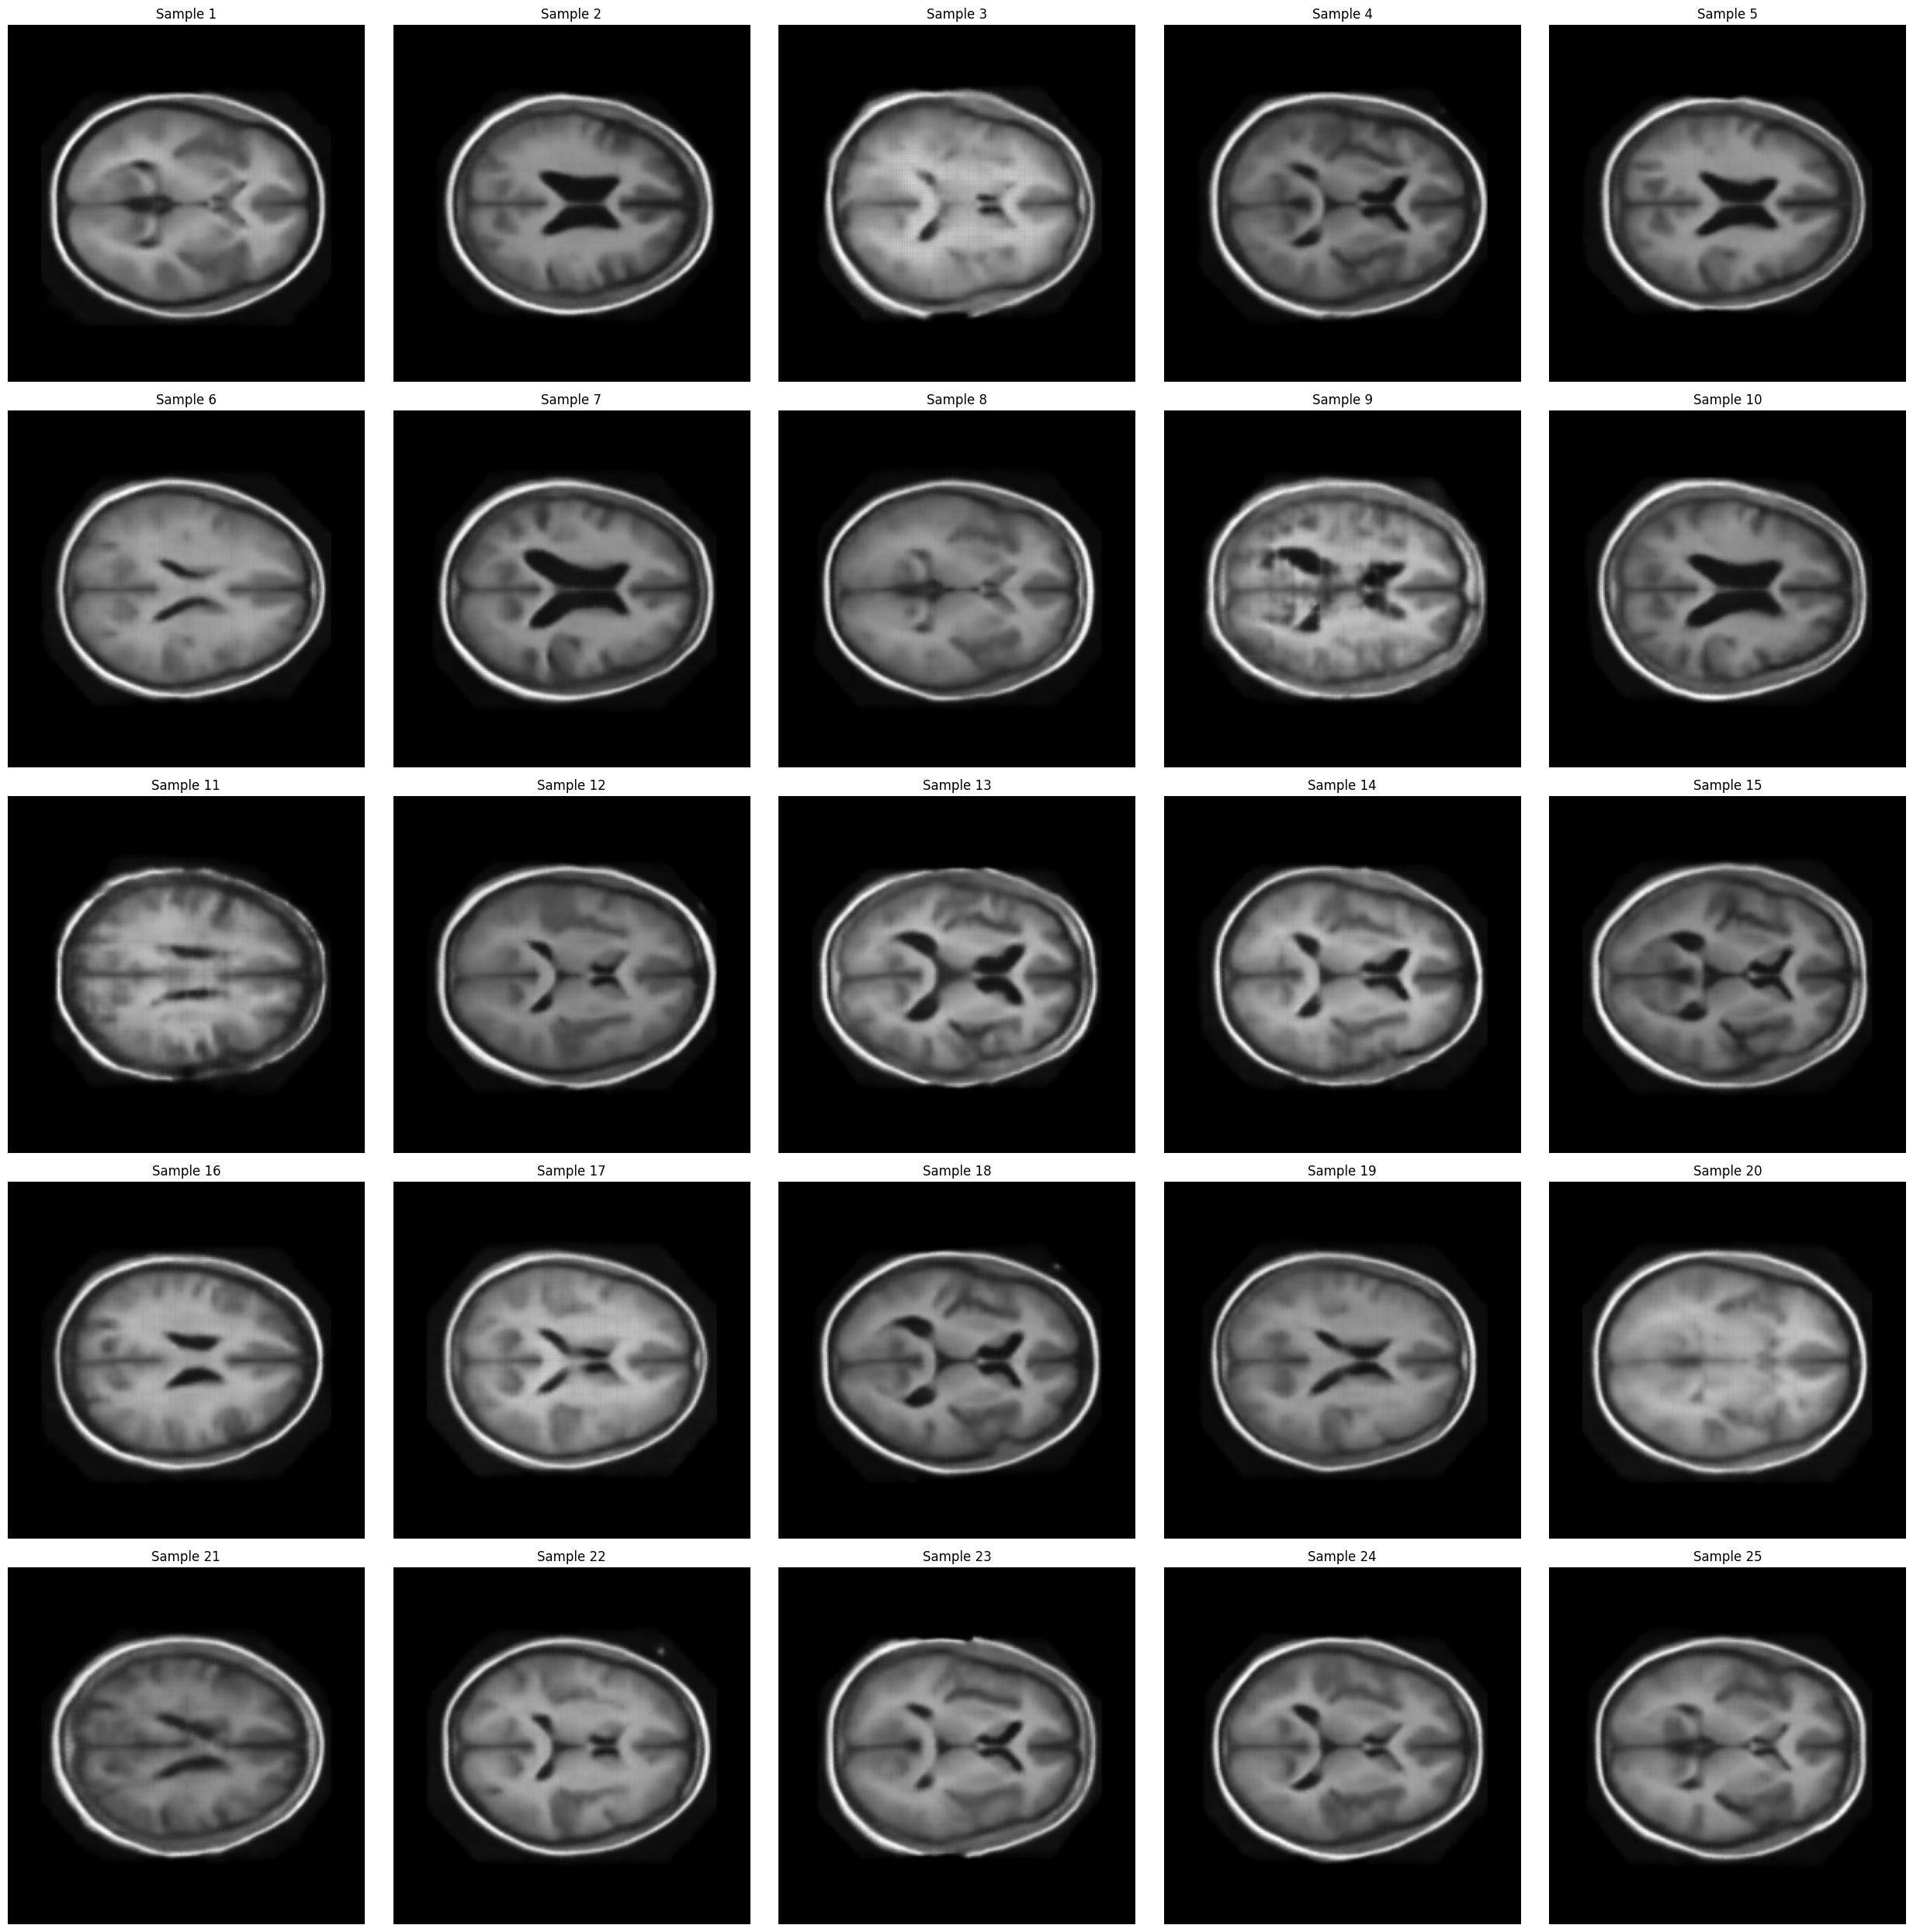

In [ ]:
import math

# Generate a random brain scan
def generate_scan(number_of_image=5, latent_dim_z=128):
    vae.eval()  # set to eval mode
    
    row_num = math.ceil(number_of_image / 5)
    col_num = min(number_of_image, 5)

    fig, axes = plt.subplots(row_num, col_num, figsize=(col_num * 5, row_num * 5))

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    with torch.no_grad():
        for i in range(number_of_image):
            z_sample = torch.randn(1, latent_dim_z).to(device)
            x_decoded = vae.decode(z_sample)
            scan = x_decoded.squeeze().cpu().reshape(256, 256)  # shape: (256, 256)

            axes[i].imshow(scan, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"Sample {i+1}")

    plt.tight_layout()
    plt.show()

generate_scan(25)

Interesting to note that there are always 32 slices, so you could actually label each of the slices and group accordingly

C:\Users\Connor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Connor\AppData\Local\Temp\ipykernel_13624\3333252659.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)


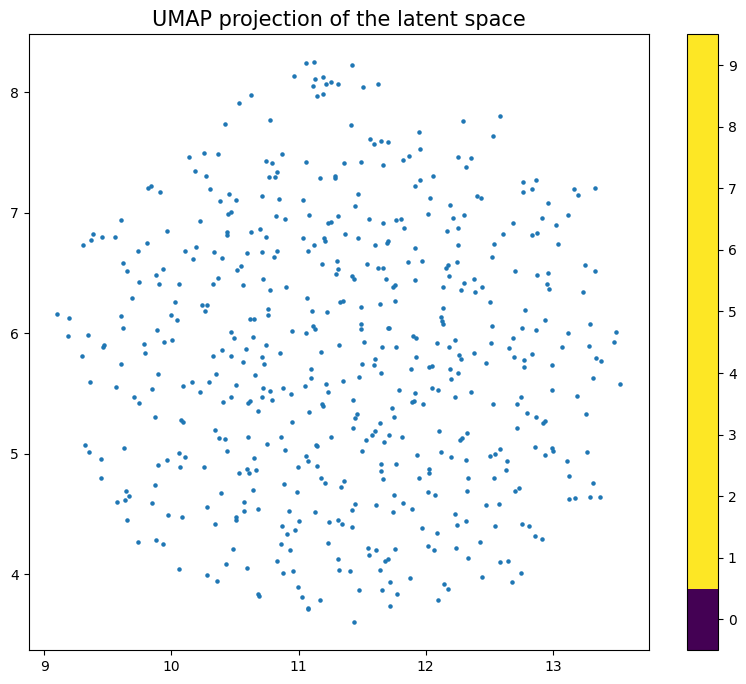

In [ ]:
# Use UMAP to visualise the latent space
import umap

# Set the model to evaluation mode
vae.eval()

# Collect latent vectors for the entire training dataset
latent_vectors = []

# Iterate over the batches in the training DataLoader
for batch in test_loader:
    with torch.no_grad():
        # Find the mean and log variance
        mean, logvar = vae.encode(batch.to(device))
        # Reparameterization trick to get the latent vector
        z = vae.reparameterization(mean, logvar)
        # Append the latent vectors to the list
        latent_vectors.append(z.cpu().numpy())

# Reduce all of the latent vectors 
latent_vectors = np.concatenate(latent_vectors, axis=0)
reducer = umap.UMAP(n_neighbors=31, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# Plot the 2D UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the latent space', fontsize=15)
plt.show()
